<a href="https://colab.research.google.com/github/Lexie-D/Breast-Cancer-Classification/blob/main/Breast_Cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load the libraries

In [19]:
#Libraries
import pandas as pd
import numpy as np
import os
import random
import cv2

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Viz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

#Image
import PIL.Image
from PIL import Image
from PIL import ImageOps
from IPython.display import display

#Tensor flow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



import requests
import zipfile
import io
import glob

# 2. Load the Dataset

In [2]:
#Uploading the dataset
from google.colab import files
uploaded = files.upload()

Saving Dataset_BUSI_with_GT.zip to Dataset_BUSI_with_GT.zip


In [3]:
#Unzipping the file
zip_path = "Dataset_BUSI_with_GT.zip"
extract_to = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

#confirm location
extracted_path = os.path.join(extract_to, "Dataset_BUSI_with_GT")
print(extracted_path)

/content/Dataset_BUSI_with_GT


In [4]:
os.listdir(extracted_path)

['malignant', 'benign', 'normal']

# 3. Read and Explore the dataset

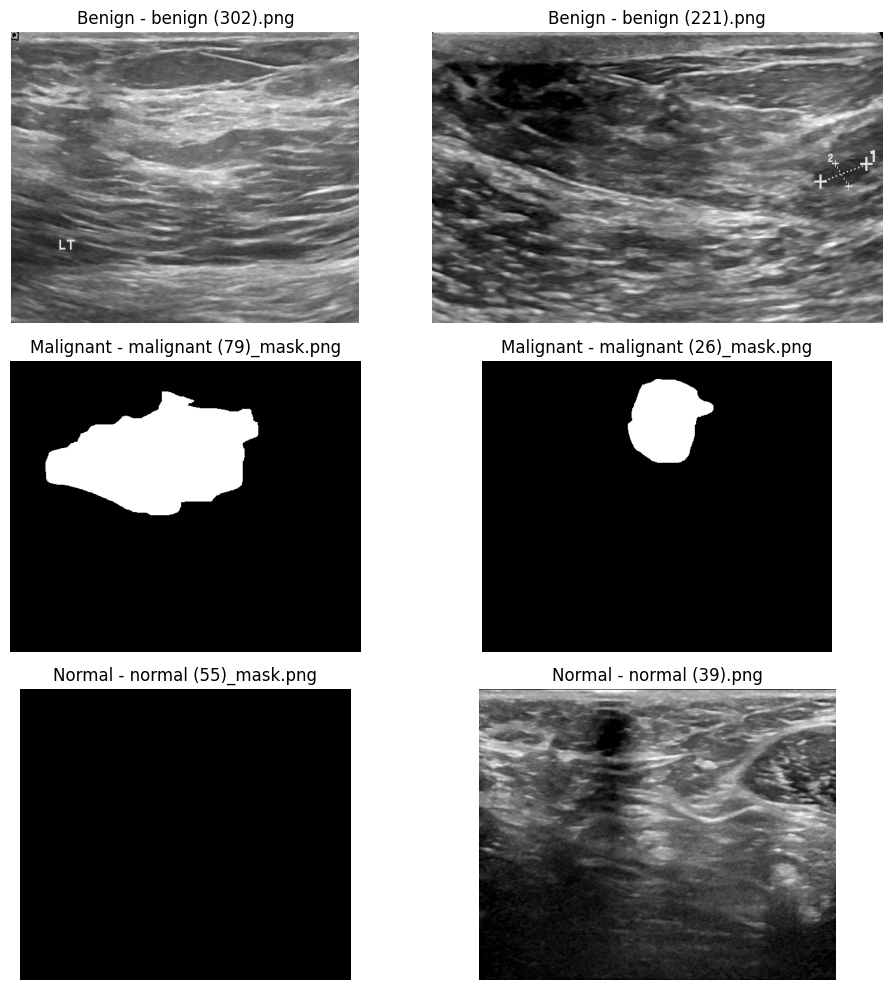

In [5]:
dataset_path = "/content/Dataset_BUSI_with_GT"
categories = ['benign', 'malignant', 'normal']

fig, axs = plt.subplots(len(categories), 2, figsize = (10, 10))

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    selected = random.sample(image_files, 2)

    for j in range(2):
        img = os.path.join(category_path, selected[j])
        img = Image.open(img).convert('L')  #images are all grey scale
        axs[i, j].imshow(img, cmap = 'grey')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{category.capitalize()} - {selected[j]}')

plt.tight_layout()
plt.show()

In [6]:
pd.DataFrame(
    os.listdir(extracted_path),
    columns = ['File Name']
)

,File Name
0,malignant
1,benign
2,normal


## All the paths in "extracted_path"

In [7]:
train_data = "/content/Dataset_BUSI_with_GT"

In [8]:
# Get all image file paths from subfolders
train_files = glob.glob(os.path.join(train_data, "*", "*.*"))

# Randomly shuffle the lists
random.shuffle(train_files)

# Extract labels from the directory names
labels = [os.path.basename(os.path.dirname(path)) for path in train_files]

# Create list of tuples (file path, label)
data = list(zip(train_files, labels))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Path", "Label"])

df

,Path,Label
0,/content/Dataset_BUSI_with_GT/benign/benign (9...,benign
1,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
2,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
3,/content/Dataset_BUSI_with_GT/normal/normal (1...,normal
4,/content/Dataset_BUSI_with_GT/normal/normal (3...,normal
...,...,...
1573,/content/Dataset_BUSI_with_GT/benign/benign (9...,benign
1574,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
1575,/content/Dataset_BUSI_with_GT/normal/normal (6...,normal
1576,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant


# 4. Data Visualizations
# Distribution of Categories (3)

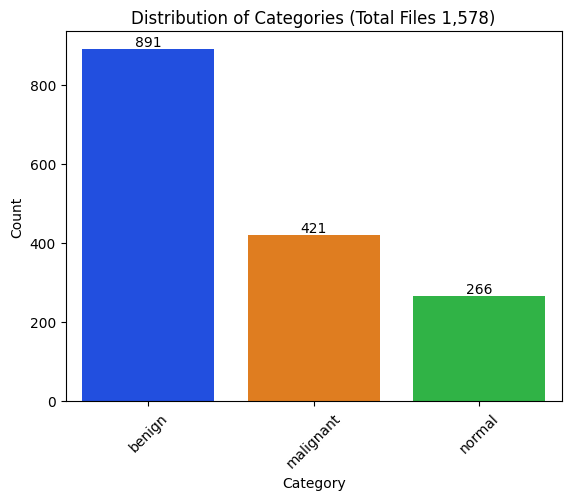

In [9]:
# Descending order
label_order = df['Label'].value_counts().sort_values(ascending = False).index

# Countplot
ax = sns.countplot(x = 'Label', data = df, order = label_order, hue = 'Label', palette = 'bright', legend = False)

# Display the counts per category above bars
for container in ax.containers:
  ax.bar_label(container)

# Plot
ax.set_title('Distribution of Categories (Total Files 1,578)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Collect Data Paths and Labels

In [10]:
# Path to "parent" dataset folder
dataset_path = "/content/Dataset_BUSI_with_GT"

# All image file paths
image_paths = glob.glob(os.path.join(dataset_path, "*", "*.png"))

# Shuffle the paths
np.random.shuffle(image_paths)

# All labels
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Create DataFrame
df = pd.DataFrame({
    'Path': image_paths,
    'Label': labels
})

df.head()

,Path,Label
0,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
2,/content/Dataset_BUSI_with_GT/normal/normal (1...,normal
3,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
4,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign


# 5. Data Preprocessing

## Using pretrained model **DenseNet121** for this project
- Best for medical imaging, smallerish datasets, and gives higher accuracy
- Images are greyscale, but with the chosen pretrained model, set to RGB
- Works best if image_size is (224, 224)

In [11]:
#set constants
image_size = (224, 224)
batch_size = 32
random_state = 42

## Split the Dataset
- 70% train
- 15% validation
- 15% test

In [14]:
# Split into training-test and validation-test sets
train_val_df, test_df = train_test_split(df, test_size = 0.15, stratify = df['Label'], random_state = 42)

# Split validation-test set into validation and test sets
val_df, train_df = train_test_split(train_val_df, test_size = 0.5, stratify = train_val_df['Label'], random_state = 42)

## Image Generator

In [17]:
# Defining image settings
image_size = (224, 224)
batch_size = 32
seed = 42

# Creating data generators
train_datagen = ImageDataGenerator(
    rescale = 1./255,               #normalize the pixel values [0,1]
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

# Creating generators, for train, validation, and test using flow_from_dataframe
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',          #have to use RBG with DenseNet112
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batch_size,
    seed = seed
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batch_size,
    seed = seed
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batch_size,
    seed = seed
)


Found 671 validated image filenames belonging to 3 classes.
Found 670 validated image filenames belonging to 3 classes.
Found 237 validated image filenames belonging to 3 classes.


In [18]:
print(train_gen.class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


# 6. Build the Model (DenseNet121)

In [22]:
base_model = DenseNet121(
    weights = 'imagenet',  #loaded with library
    include_top = False,
    input_shape = (224, 224, 3)
)

# Freeze layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential()

# Add pre-trained model (DenseNet121)
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add fully connected layers with dropout to regularize it
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

# Softmax layer for 3-way classification
model.add(Dense(3, activation = 'softmax'))

# Show model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,059,203 (229.11 MB)

 Trainable params: 53,021,699 (202.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [23]:
# Save the summary to a text file
with open("model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

!cat model_summary.txt

Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼───────────────────

## Visualize the Convolutional Neural Network